In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [4]:
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

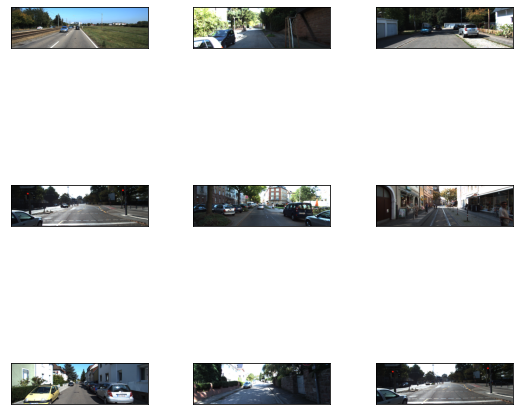

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

In [6]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

- 데이터셋 개수: (train=6347, test=711, valid=423)
- 라벨 분석
  - alpha: 물체의 관찰 각도 (카메라 각도) [-pi..pi]
  - bbox: 각 이미지에 대한 2D bounding box (우상단, 좌하단 좌표)
  - dimensions: 3D 물체에 대한 height, width, length
  - location: 3D 물체에 대한 위치: x, y, z
  - occluded: 보이는 정도? 0=완전 보임, 1=부분적으로 보임, 2=거의 안보임, 3=알 수 없음
  - rotation_y: 카메라 좌표 [-pi..pi]에서 Y축을 중심으로 회전
  - truncated: 물체의 잘림 정도, 0=잘리지 않음, 1=잘림
  - type: 객체의 유형에 대한 설명 '자동차', '밴', '트럭', '보행자', '앉은 사람', '자전거 타는 사람', '운반차' 등등


In [7]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.64, -1.73, -1.27,  1.92,  1.77,  1.7 , -1.5 ,  1.66],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[0.17676471, 0.49588853, 0.56914437, 0.54193056],
       [0.19227272, 0.54339254, 0.59090906, 0.5897011 ],
       [0.14858289, 0.19015348, 0.576631  , 0.23835218],
       [0.0026738 , 0.19573505, 0.5806417 , 0.30926496],
       [0.26671124, 0.3434895 , 0.55326205, 0.3988126 ],
       [0.3351337 , 0.35854605, 0.5575668 , 0.39002424],
       [0.38852942, 0.5875929 , 0.5652674 , 0.60132474],
       [0.45256683, 0.38852182, 0.553369  , 0.4220517 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[1.73, 0.84, 0.86],
       [1.81, 0.9 , 0.95],
       [1.78, 0.92, 1.01],
       [1.81, 0.65, 1.7 ],
       [1.7 , 0.81, 1.72],
       [1.79, 0.62, 1.9 ],
       [1.63, 0.61, 0.82],
       [2.11

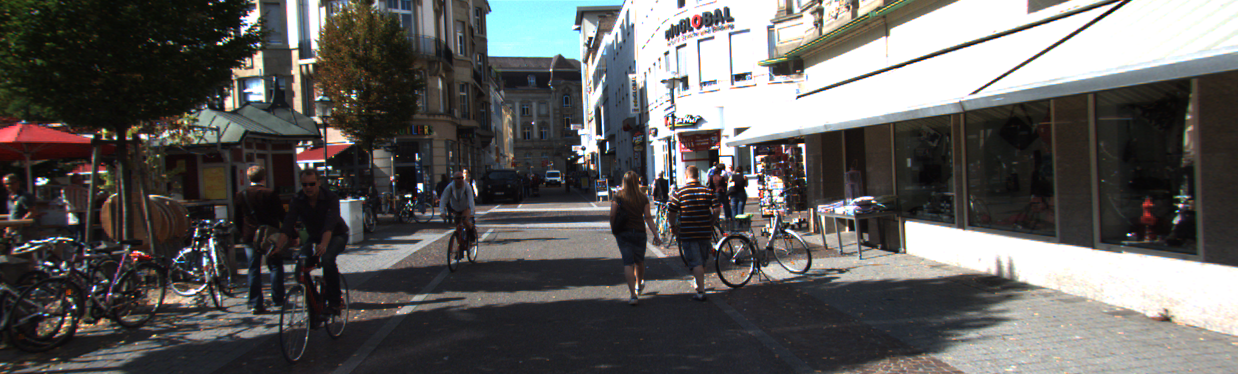

In [8]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

1238 374
(8, 4)


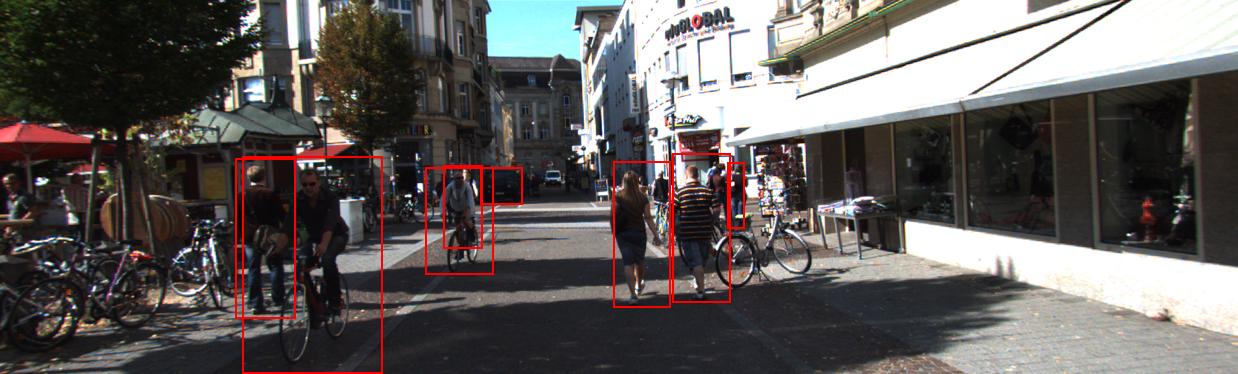

In [10]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print(width, height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

사람은 빨간색 bounding box로 표시했습니다

## 클래스 및 바운딩 박스 정보 추출

In [11]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df
    
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [12:03<00:00,  8.78it/s]


In [12]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:20<00:00,  8.88it/s]


In [13]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

In [14]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt

2020-10-21 18:33:02.850204: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 18:33:03.940968: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-21 18:33:03.945149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-21 18:33:03.945461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-10-21 18:33:03.945477: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 18:33:03.947350: I tensorflow/stream_executor/platform

In [15]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_10.h5 ./snapshots/resnet50_csv_50_infer.h5

2020-10-21 19:25:50.836318: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 19:25:52.177564: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-21 19:25:52.181878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-21 19:25:52.182197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-10-21 19:25:52.182211: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-21 19:25:52.185364: I tensorflow/stream_executor/platform

In [1]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

1 Physical GPUs, 1 Logical GPUs


[589.87885 173.91165 626.238   206.20534]


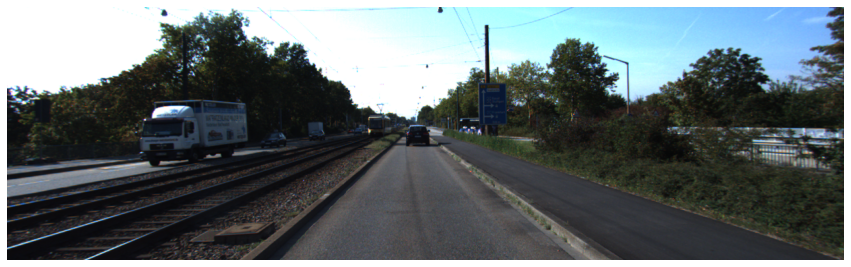

In [9]:
import os
img_path = 'data/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[777.0791  153.92215 831.277   312.0049 ]
[793.56726 153.32076 848.7203  300.37677]


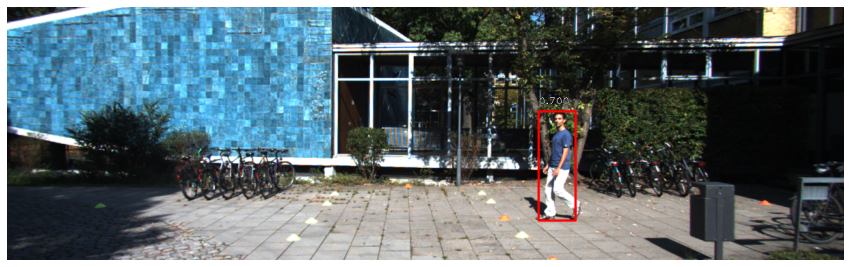

In [10]:
img_path = 'data/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

학습 결과 정확히 사람이 빨간색 box로 표시되는 결과를 볼 수 있습니다. score는 0.70입니다. 

In [6]:
img_path = 'data/test_set/stop_3.png'

def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # 만약 사람이 1명 이상이면 멈춘다.
        if label == 1:
            return "Stop"
        
        elif label == 0:
            width = box[2] - box[0]
            height = box[3] - box[1]
            # 사람이 아닌 경우 width와 height 둘 중 하나가 300 이상이면 'Stop'
            if width > 300 or height > 300:
                return "Stop"
        # 둘다 아니라면 그냥 간다.    
        if score < 0.5:
            return "Go"

print(self_drive_assist(img_path)) 

Stop


In [7]:
import os

def test_system(func):
    work_dir = 'data/'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.


## Report

KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3d object detection 라벨을 제공하고 있다. 아직은 object Detection에 대한 지식을 배우느라 2D 라벨만 활용하지만, 기회가 되면 depth 정보를 활용한 3차원 Detection도 하고 싶다. 그리고 좀 더 많은 test 이미지로 다양한 테스트를 해보고 싶었지만, 이미지로 된 데이터를 구하기 힘들었다. 

함수를 평가하는 방법도 사람인지 아닌지, 또 자동차면 어느정도 사이즈가 되는 지에 따라 달라진다. 자율주행의 핵심은 원하는 위치에 스스로 가는 것이지만, 안전이 최우선이기 때문에 사람이나 가까운 자동차가 있으면 무조건 Stop을 해야된다. 더욱 다양한 상황을 실험해보고 싶지만 모델이 정상적으로 작동하는 모습을 보고 만족했다.